In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from multiprocessing import Pool
import time
import dill
from PIL import Image

In [246]:
def show_img(img):
    cv2.imshow("img", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
def show_plt_img(img_in):
    img = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
def print_max_min_median(M):
    print(f"max={M.max()}, min={M.min()}, median={np.median(M)}")

### We perform the proposed algorithm on endoscopic images under design parameters α = 0.05, β1 ∈ [1, 5], β2 = 0.1, and τ ∈ [0.01, 0.1], and on natural images under design parameters α = 0.1, τ = 0.01, β1 = 3, and β2 = 0.1.

In [296]:
alpha = 0.1
theta = 0.01
sigma = 0.01
B1 = 3
B2 = 0.1 

In [247]:
def make_square(im, min_size=256, fill_color=(0, 0, 0, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGBA', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

image = Image.open('fish.ppm')
new_image = make_square(image)
new_image.save('fish_square.ppm', 'PPM')

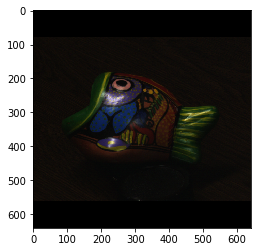

In [266]:
img = cv2.imread('fish_square.ppm').astype('float32') / 255.0
# show_img(img)
show_plt_img(img)


In [267]:
print_max_min_median(img)

max=0.9450980424880981, min=0.0, median=0.03529411926865578


### Compute H(x); S(x); V(x)g by HSV transformation

In [343]:
hsv_img = cv2.cvtColor(cv2.imread('fish_square.ppm'), cv2.COLOR_BGR2HSV).astype('float32') / 255.0
H, S, V = hsv_img[:, :, 0], hsv_img[:, :, 1], hsv_img[:, :, 2]
# plt.imshow(hsv_img)
# show_img(hsv_img)

In [344]:
print_max_min_median(H)
print_max_min_median(S)
print_max_min_median(V)

max=0.7019608020782471, min=0.0, median=0.05098039284348488
max=0.9647058844566345, min=0.0, median=0.364705890417099
max=0.9450980424880981, min=0.0, median=0.05098039284348488


In [345]:
print_max_min_median(hsv_img)

max=0.9647058844566345, min=0.0, median=0.05882352963089943


In [355]:
hsv_to_bgr = cv2.cvtColor(hsv_img.copy(), cv2.COLOR_HSV2BGR)
print_max_min_median(hsv_to_bgr)
print_max_min_median(img)

max=0.9450980424880981, min=0.0, median=0.03141868859529495
max=0.9450980424880981, min=0.0, median=0.03529411926865578


In [357]:
diff = img - hsv_to_bgr
print_max_min_median(diff)

max=0.4138889014720917, min=-0.35294121503829956, median=0.0


In [359]:
img__ = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2HSV), cv2.COLOR_HSV2BGR)

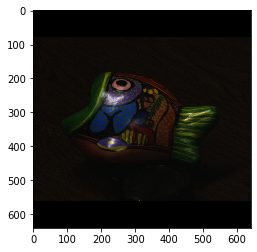

In [342]:
_test = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
plt.imshow(_test)

### Compute highlight detection sets by (8) and (9)


In [195]:
def show_with_mask(img, mask):
    coef_indxs = np.copy(mask)
    coef_indxs[coef_indxs == True] = 1
    coef_indxs[coef_indxs == False] = 0
    _3d_coef_indxs = np.repeat(coef_indxs[:, :, np.newaxis], 3, axis=2)
    plt.imshow(img * _3d_coef_indxs)

#### 8 $X_{SV}$(x) = {x| S(x) < α; V(x) > 1 − α}

In [278]:
# X_SV = np.array(S < alpha) & np.array(V > (1 - alpha))
X_SV = np.array(S < alpha) | np.array(V > (1 - alpha))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


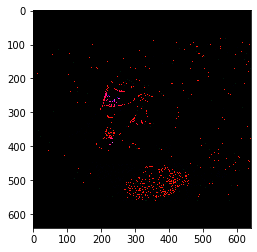

In [279]:
show_with_mask(hsv_img, X_SV)

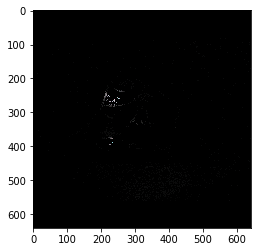

In [280]:
show_with_mask(img, X_SV)

#### 9 $X_G(x) = \{x|G(x) ≥ τ \}$

gradient magnitude of dark-channel image $\hat{I}(x) = min_{c∈{r,g,b}} I_c(x)$

In [284]:
I_b, I_g, I_r = cv2.split(img)
I_gmd = np.minimum(I_b, I_g, I_r)
I_gmd = I_gmd 

In [285]:
print_max_min_median(I_gmd)

max=0.8117647171020508, min=0.0, median=0.0313725508749485


$G(x) =\frac{\sqrt{(\hat{I}(x+1,y)−\hat{I}(x−1,y))^2+(\hat{I}(x,y+1)−\hat{I}(x,y−1))^2}}{2}$


In [286]:
G = cv2.Laplacian(I_gmd, cv2.CV_32F)

### theta change!!!

In [294]:
# theta = 0.04

In [299]:
X_G = np.array(G >= theta)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


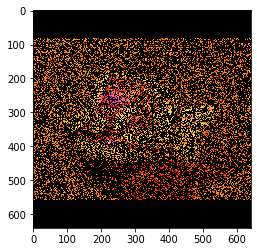

In [300]:
show_with_mask(hsv_img, X_G)

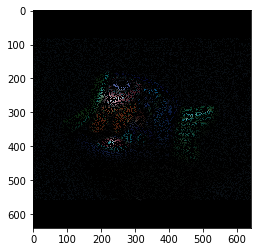

In [301]:
show_with_mask(img, X_G)

### Compute Hue estimate $H^∗$(x) by (11)
### Compute Saturation estimate $S^∗$(x) by (12)

#### We propose a joint HSV and RGB-space detection set as below
#### $X_{SVG}(x) = X_{SV}(x) \cup X_G(x)$

In [302]:
X_SVG = X_SV | X_G

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


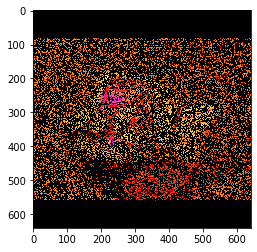

In [303]:
show_with_mask(hsv_img, X_SVG)

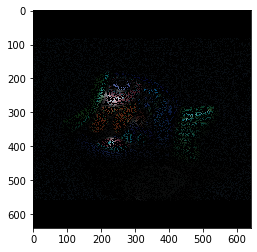

In [304]:
show_with_mask(img, X_SVG)

$\begin{aligned} w_{S V G}(\mathbf{x}) &=\left\{\begin{array}{ll}\alpha, & \mathbf{x} \in X_{S V G}(\mathbf{x}) \\ 1, & \text {else}\end{array}\right.\\ 
\end{aligned}$   $~~~~~\mathbf{(13)}$

In [305]:
W_svg_matrix = np.ones(X_SVG.shape).astype('float32')
W_svg_matrix[X_SVG == True] = alpha
W_svg_matrix[X_SVG == False] = 1
np.unique(W_svg_matrix)

array([0.1, 1. ], dtype=float32)

### _____

$\begin{aligned} w_{H S}(\mathbf{x}, \mathbf{u})=e^{\left(\frac{-(\mathbf{H}(\mathbf{x})-\mathbf{H}(\mathbf{u}))^{2}}{\sigma^{2}}\right.} e^{\left.-(1-\mathbf{S}(\mathbf{u}))^{2}\right)} \end{aligned}$

### _____

$\mathbf{H}^{*}(x)=\frac{1}{\sum_{u \in \Omega(\mathbf{x})} w_{S V G}(\mathbf{u})} \sum_{u \in \Omega(\mathbf{x})} \mathbf{H}(\mathbf{u}) w_{S V G}(u)$     $~~~~~\mathbf{(11)}$

$\mathbf{S}^{*}(x)=\frac{1}{\sum_{u \in \Omega(\mathbf{x})} w_{H S}(\mathbf{x}, \mathbf{u})} \sum_{u \in \Omega(\mathbf{x})} \mathbf{S}(\mathbf{u}) w_{H S}(\mathbf{x}, \mathbf{u})$    $~~~~~\mathbf{(12)}$

In [306]:
def calc_size(point, shape, window_size):
    result = [0, 0, 0, 0]
    y, x = point
    edge = (window_size - 1) // 2
    result[0] = max(y - edge, 0)
    result[1] = min(shape[0], y + edge) 
    
    result[2] = max(x - edge, 0) 
    result[3] = min(x + edge, shape[1]) 
    return result 

def get_part(size, matrix):
    return matrix[size[0] : size[1], size[2] : size[3]]

def get_whs(H_x, H_part, S_part):
    #     mb mistake in paper
#     return np.exp(-(H_x - H_part) ** 2) * np.exp(-(1 - S_part) ** 2) / sigma ** 2
    return np.exp(-(H_x - H_part) ** 2) * np.exp(-(1 - S_part ** 2) ) / sigma ** 2

In [307]:
%%time
window_size = 7
# H_11 = np.zeros(X_SVG.shape)
# S_12 = np.zeros(X_SVG.shape)
# H_11 = np.ones(X_SVG.shape)
# S_12 = np.ones(X_SVG.shape)
H_11 = H.astype('float32')
S_12 = S.astype('float32')

for y in range(X_SVG.shape[0]):
    for x in range(X_SVG.shape[1]):
        if X_SVG[y, x]:
            size = calc_size((y, x), X_SVG.shape, window_size)
            H_part = get_part(size, H)
            S_part = get_part(size, S)        
           
            wsvg = get_part(size, W_svg_matrix)
            H_svg = H_part * wsvg
            H_11[y, x] = (1 / wsvg.sum()) * H_svg.sum()
            
            whs = get_whs(H[y, x], H_part, S_part)
            S_whs = whs * S_part
            S_12[y, x] = (1 / whs.sum()) * S_whs.sum()

Wall time: 6.28 s


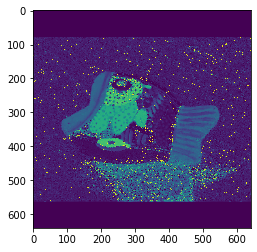

In [308]:
plt.imshow(H_11)

In [310]:
print_max_min_median(H_11)

max=358.8888854980469, min=0.0, median=26.18602752685547


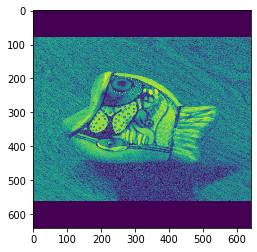

In [309]:
plt.imshow(S_12)

In [311]:
print_max_min_median(S_12)

max=0.9657984375953674, min=0.0, median=0.3636353611946106


### Compute diffuse chromaticity estimate by (15)

$\Lambda^{*}(\mathbf{x})=\varphi^{-1}\left(I_{H}^{*}, I_{S}^{*}, 1\right)$  

where $\varphi^{-1}$  is the inverse transformation from HSV color
space to RGB color space

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dtype('float32')

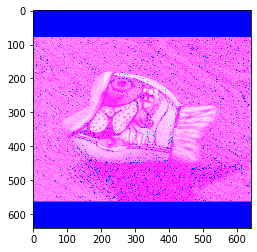

In [213]:
_hsv_img_HS1 = np.ones(hsv_img.shape).astype('float32')
_hsv_img_HS1[:, :, 0] = H_11
_hsv_img_HS1[:, :, 1] = S_12
plt.imshow(_hsv_img_HS1)
_hsv_img_HS1.dtype

In [216]:
diff_hsv = np.abs(hsv_img - _hsv_img_HS1)
np.max(diff_hsv), np.min(diff_hsv), np.median(diff_hsv)

(322.87714, 0.0, 0.0)

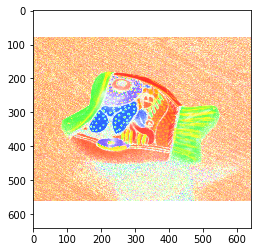

In [214]:
# _diff_chrom = cv2.cvtColor(_hsv_img_HS1.astype('float32'), cv2.COLOR_HSV2RGB)
_diff_chrom = cv2.cvtColor(_hsv_img_HS1, cv2.COLOR_HSV2RGB)
# _diff_chrom = cv2.cvtColor(_hsv_img_HS1, cv2.COLOR_HSV2RGB)
plt.imshow(_diff_chrom)
# show_img(_diff_chrom)

### Compute $m^∗_d$(x) by updating algorithm (25)

\begin{array}{l}
m_{d}^{k+1}(\mathbf{x})=P_{\Omega_{1}}\left[m_{d}^{k}(\mathbf{x})-h_{k} \frac{\partial E}{\partial m_{d}}\left(m_{d}^{k}(\mathbf{x}), m_{s}^{k}(\mathbf{x}), \mathbf{q}^{k}(\mathbf{x})\right)\right] \\
m_{s}^{k+1}(\mathbf{x})=P_{\Omega_{2}}\left[m_{s}^{k}(\mathbf{x})-h_{k} \frac{\partial E}{\partial m_{s}}\left(m_{d}^{k}(\mathbf{x}), m_{s}^{k}(\mathbf{x}), \mathbf{p}^{k}(\mathbf{x})\right)\right] \\
\mathbf{p}^{k+1}(\mathbf{x})=P_{\Omega_{3}}\left[\mathbf{p}^{k}(\mathbf{x})-h_{k} \beta_{2} \nabla m_{s}^{k}(\mathbf{x})\right] \\
\mathbf{q}^{k+1}(\mathbf{x})=\mathbf{q}^{k}(\mathbf{x})-h_{k} \beta_{1}\left(\nabla m_{d}^{k}(\mathbf{x})-\mathbf{q}^{k}(\mathbf{x})\right)
\end{array}

In [171]:
def P1(u):
    u[u < 0] = 0
    u[u > 1] = 1
    return u

def P2(u):
    u[u < 0] = 0
    u[u > 1] = 1
    return u

def P3(u):
    u[u < -1] = -1
    u[u > 1] = 1
    return u

In [172]:
def gen_1(shape):
    return np.random.rand(*shape) * 0.001
#     return np.random.choice(np.arange(0.3, 0.8, 0.001), shape)

def gen_2(shape):
    return np.random.choice(np.arange(-1, 1, 0.001), shape)* 0.001

In [173]:
_Gamma = np.ones(img.shape)
_Gamma[:,:,0] = 1 - cv2.blur(I_r, (3,3))
_I = img / 255

In [174]:
shape = img.shape
_m_d, _m_s = gen_1(shape), gen_1(shape)
_p_x, _p_y  = gen_2(shape), gen_2(shape)
_q_x, _q_y  = gen_2(shape), gen_2(shape)
h = 0.01

In [175]:
%%time
for color in range(3):
    m_d, m_s  = _m_d[:, :, color], _m_s[:, :, color]
    p_x, p_y  = _p_x[:, :, color], _p_y[:, :, color]
    q_x, q_y  = _q_x[:, :, color], _q_y[:, :, color]
    Gamma = _Gamma[:,:, color]
    I = _I[:,:, color]
    diff_chrom = _diff_chrom[:, :, color]
    k = [p_x, p_y
        ,q_x, q_y
        ,m_d, m_s ]
    for _ in range(50):
        p_x_k, p_y_k, q_x_k, q_y_k, m_d_k, m_s_k = k

        g_m_s_x, g_m_s_y = np.gradient(m_s_k)
        p_x = P3(p_x_k - h * B2 * g_m_s_x)
        p_y = P3(p_y_k - h * B2 * g_m_s_y)

        g_m_d_x, g_m_d_y = np.gradient(m_d_k)
        q_x = q_x_k - h * B1 * (g_m_d_x - q_x_k)
        q_y = q_y_k - h * B1 * (g_m_d_y - q_y_k)

        div_p = np.sum(np.gradient(p_x_k), axis=0) + np.sum(np.gradient(p_y_k), axis=0)
        dE_dm_s = (m_d_k * diff_chrom + m_s_k * Gamma - I).T * Gamma - B2 * div_p
#         dE_dm_s = (m_d_k * diff_chrom + m_s_k * Gamma - I) * Gamma - B2 * div_p
        m_s = P2(m_s_k - h * dE_dm_s)

        div_q = np.sum(np.gradient(q_x_k), axis=0) + np.sum(np.gradient(q_y_k), axis=0)
        dE_dm_d = (m_d_k * diff_chrom + m_s_k * Gamma - I).T * diff_chrom - B1 * div_q
#         dE_dm_d = (m_d_k * diff_chrom + m_s_k * Gamma - I) * diff_chrom - B1 * div_q
        m_d = P1(m_d_k - h * dE_dm_d)

        k = [p_x, p_y
            ,q_x, q_y
            ,m_d, m_s ]
    
    _m_d[:, :, color], _m_s[:, :, color]  = m_d, m_s 
    _p_x[:, :, color], _p_y[:, :, color]  = p_x, p_y 
    _q_x[:, :, color], _q_y[:, :, color]  = q_x, q_y 

Wall time: 23.9 s


###  Compute $I^∗_D$(x) = $m^∗_d$(x)$\Lambda^∗$(x)

In [176]:
np.max(_m_d), np.mean(_m_d), np.median(_m_d)

(0.7108297655731401, 0.015904881901234364, 0.00939298033399059)

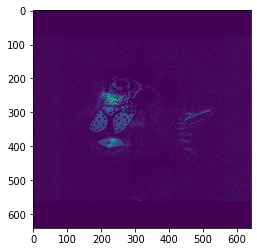

In [177]:
plt.imshow(_m_d[:,:,0].T)

In [178]:
I_D = _m_d * _diff_chrom

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


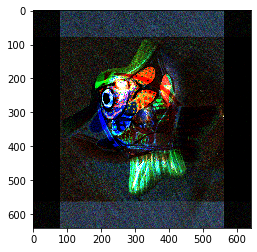

In [179]:
plt.imshow(I_D*10)

In [180]:
_m_d[:,:,0] = _m_d[:,:,0].T
_m_d[:,:,1] = _m_d[:,:,1].T
_m_d[:,:,2] = _m_d[:,:,2].T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


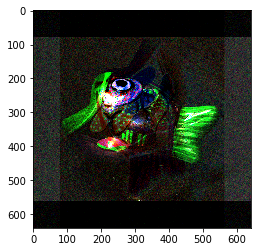

In [181]:
plt.imshow(_m_d * _diff_chrom*10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


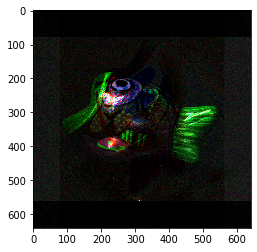

In [182]:
plt.imshow(_m_d * _diff_chrom * 5)